In [1]:
import torch
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset 
#above class we used to create custom dataset class which helping us to prepare batch_size data
import pandas as pd
import numpy as np

In [2]:
#now loading the insurance data
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [3]:
#selecting input and output variable
x = data.drop('insuranceclaim',axis=1)
y = data['insuranceclaim']

In [4]:
#splitting the data into training and testing set
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [5]:
#checking shape of training and testing set
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1070, 7), (268, 7), (1070,), (268,))

In [6]:
x_train.dtypes,x_test.dtypes,y_train.dtypes,y_test.dtypes

(age           int64
 sex           int64
 bmi         float64
 children      int64
 smoker        int64
 region        int64
 charges     float64
 dtype: object,
 age           int64
 sex           int64
 bmi         float64
 children      int64
 smoker        int64
 region        int64
 charges     float64
 dtype: object,
 dtype('int64'),
 dtype('int64'))

In [7]:
#now doing input scaling by using standard scaler class
#creating an object of standard scaler class
ss = StandardScaler()

x_train = ss.fit_transform(x_train) #change 2d pandas object to 2d numpy array object
x_test = ss.transform(x_test)       #change 2d pandas object to 2d numpy array object

In [8]:
type(x_train),type(x_test),x_train.ndim,x_test.ndim

(numpy.ndarray, numpy.ndarray, 2, 2)

In [9]:
#now changing output variable to numpy array object
y_train_np = np.array(y_train,dtype=np.float32)
y_test_np = np.array(y_test,dtype=np.float32)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
torch.__version__

'2.7.1+cu118'

# now changing the dtype to float-32 for training and testing set

In [12]:
x_train_tensor = torch.from_numpy(x_train).float()
x_test_tensor = torch.from_numpy(x_test).float()

y_train_tensor = torch.from_numpy(y_train_np)
y_test_tensor = torch.from_numpy(y_test_np)
type(y_test_tensor),y_test_tensor.dtype

(torch.Tensor, torch.float32)

# now creating custom dataset class which load the data and split the data based on batch_size 

In [13]:
class CustomDataset(Dataset): #inheriting the property method classes from parent class Dataset
    #creating constructor method to initialize the instance variable in it.
    def __init__(self,input_data,output_data):
        
        #calling the parent class constructor
        super().__init__()
        self.input_data = input_data
        self.output_data = output_data
        
    #creating another magical method class to get the the size of input_data
    def __len__(self):
        return len(self.input_data)
    
    #creating another magical method class to get batch data based on index provided by user
    def __getitem__(self, index):
        return self.input_data[index],self.output_data[index]

In [14]:
#now creating and object of training and testing dataset
training_dataset = CustomDataset(x_train_tensor,y_train_tensor)
testing_dataset  = CustomDataset(x_test_tensor,y_test_tensor)

# now calling dataloader class

In [15]:
#dataloader will load the data in batch size and also having availability to run on gpu
training_dataloader_set = DataLoader(training_dataset,batch_size=8,shuffle=True,pin_memory=True)
testing_dataloader_set = DataLoader(testing_dataset,batch_size=8,shuffle=True,pin_memory=True)

In [16]:
for feature,label in training_dataloader_set:
    print(feature)
    print(label)
    break

tensor([[ 1.2542,  0.9760,  1.9153, -0.0884,  1.9656,  0.4410,  2.9407],
        [ 0.1168,  0.9760,  1.0743,  0.7343, -0.5087, -0.4561, -0.5061],
        [-0.1676,  0.9760,  0.6025, -0.0884,  1.9656, -1.3533,  2.1393],
        [ 1.6096, -1.0246,  1.4303, -0.9112, -0.5087,  1.3382,  0.0104],
        [ 0.5433, -1.0246, -0.4826,  0.7343,  1.9656, -0.4561,  0.9314],
        [-0.3097, -1.0246, -0.7343, -0.9112, -0.5087, -1.3533, -0.6757],
        [-1.0917,  0.9760,  0.0835, -0.9112,  1.9656, -1.3533,  1.7403],
        [-0.2386,  0.9760, -0.3254,  1.5571, -0.5087, -0.4561, -0.5658]])
tensor([1., 1., 1., 1., 1., 1., 1., 0.])


In [17]:
x_train_tensor.shape

torch.Size([1070, 7])

# now defining the neural network architecture

In [18]:
from torch.nn import Sequential

class MyNeuralNetwork(nn.Module):
    #creating constructor method to initialize the neurons structure in it.
    def __init__(self,input_feature_size):
        #inheriting the constructor property from parent class
        super().__init__()
        
        #now defining sequential model init.
        self.model = Sequential(
            
            #defining the 1st hidden layer inputs
            nn.Linear(input_feature_size,6),
            nn.BatchNorm1d(6),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            #defining the 2st hidden layer inputs
            nn.Linear(6,4),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            #defining the output layer input
            nn.Linear(4,1),
            nn.Sigmoid()
            
        )
        
    #creating another method to perform forward pass calculation and passing input to neural structure
    def forward(self,inputs):
        return self.model(inputs)

In [19]:
#creating an object of custom MyNeuralNetwork class
in_feature = x_train_tensor.shape[1]
model = MyNeuralNetwork(in_feature).to(device=device)
model

MyNeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=6, bias=True)
    (1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=6, out_features=4, bias=True)
    (5): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=4, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [20]:
#to show how many trainable parameter will be trained by this model
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
MyNeuralNetwork                          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       48
│    └─BatchNorm1d: 2-2                  12
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       28
│    └─BatchNorm1d: 2-6                  8
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       5
│    └─Sigmoid: 2-10                     --
Total params: 101
Trainable params: 101
Non-trainable params: 0

In [21]:
#now defining how many iteration/epochs want to give to this model
#as well as defining optimizers will update the trainable in each layer

epochs = 30
optimizers = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.01)#here weight decay means l2 reqularization

In [22]:
#defining type of loss function using based on pblm statement
loss = torch.nn.BCELoss()

In [23]:
#creating list of object that storing average training loss and testing loss variance in it
avg_training_loss = []
avg_testing_loss  = []
for epoch in range(epochs):
    
    #initializing training loss count variable to zero
    training_loss = 0
    model.train()
    #loading the data into batch size and passing them to neural netork architecutre
    for train_feature,train_label in training_dataloader_set:
        #now this train feature and label we gonna train through GPU
        train_feature = train_feature.to(device)
        train_label   = train_label.to(device)
        
        #first algorithm that work in neural network architecutre is forward propogation algorithm and genearte predicted output
        y_pred = model.forward(train_feature)
    
        #now evaluating the training performance by calcculating the loss function
        losses = loss(y_pred.squeeze(),train_label) #squeeze changing dimension so that it match the dimension of prediction output
        
        training_loss = training_loss+losses.item()
        
        #now ensuring optimizer will have no graident in it after each iteration 
        #bcoz if we dont make it zero gradient of previous epoch will get added in existing graident mei
        optimizers.zero_grad()
    
        #reducing the loss value by doing backporopgation in which we r finding trainable parameter gradients in it.
        losses.backward() #will calculate gradients of all trainable parameter
        
        #updating the trainiable parameter in each layers
        optimizers.step()
     
    #calculating avgerage training loss in all iteration
    avg_train_loss = training_loss/(len(training_dataloader_set))
    avg_training_loss.append(avg_train_loss)   
        
    #initializing testing loss count variable to zero
    #testing data pe we dont apply backpropogation and reqularization and dropout 
    testing_loss = 0
    model.eval()
    model_predicted_output_count_per_batch = 0
    total_count_per_batch = 0
    
    #evaluation time we dont wan tto track the gradient
    with torch.no_grad():
        for test_feature,test_label in testing_dataloader_set:
            #now this train feature and label we gonna train through GPU
            test_feature = test_feature.to(device)
            test_label   = test_label.to(device)
            
            #first algorithm that work in neural network architecutre is forward propogation algorithm and genearte predicted output
            prediction_output = model.forward(test_feature)
        
            #now evaluating the training performance by calcculating the loss function
            losses = loss(prediction_output.squeeze(),test_label) #squeeze changing dimension so that it match the dimension of prediction output
            
            testing_loss = testing_loss+losses.item()
            
            
            #now checking how many true prediction done by model in each batch by comapring them with threshold value 0.5
            result = (prediction_output.squeeze() >=0.5).float()
            
            #calculating numbers/count true prediction done by model
            correct_predicted_by_model_per_batch = (result == test_label).sum().item()
            
            model_predicted_output_count_per_batch  = model_predicted_output_count_per_batch +correct_predicted_by_model_per_batch
            
            #total record count per batch
            count_per_batch = test_label.shape[0]

            #updating total count numbers
            total_count_per_batch = total_count_per_batch+count_per_batch
            
    
    #calculating avgerage training loss in all iteration
    avg_test_loss = testing_loss/(len(testing_dataloader_set))
    avg_testing_loss.append(avg_test_loss) 
    
    accuracy = model_predicted_output_count_per_batch/total_count_per_batch * 100  
        
    
    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, "
          f"Test Accuracy: {accuracy:.4f}")


Epoch [1/30], Train Loss: 0.7710, Test Loss: 0.7426, Test Accuracy: 40.6716
Epoch [2/30], Train Loss: 0.7276, Test Loss: 0.7129, Test Accuracy: 45.8955
Epoch [3/30], Train Loss: 0.6946, Test Loss: 0.6798, Test Accuracy: 55.2239
Epoch [4/30], Train Loss: 0.6621, Test Loss: 0.6372, Test Accuracy: 68.2836
Epoch [5/30], Train Loss: 0.6433, Test Loss: 0.6214, Test Accuracy: 72.7612
Epoch [6/30], Train Loss: 0.6217, Test Loss: 0.5848, Test Accuracy: 78.3582
Epoch [7/30], Train Loss: 0.6063, Test Loss: 0.5486, Test Accuracy: 81.7164
Epoch [8/30], Train Loss: 0.6013, Test Loss: 0.5333, Test Accuracy: 85.8209
Epoch [9/30], Train Loss: 0.5457, Test Loss: 0.5105, Test Accuracy: 84.7015
Epoch [10/30], Train Loss: 0.5394, Test Loss: 0.4779, Test Accuracy: 84.3284
Epoch [11/30], Train Loss: 0.5273, Test Loss: 0.4816, Test Accuracy: 83.2090
Epoch [12/30], Train Loss: 0.5281, Test Loss: 0.4659, Test Accuracy: 83.5821
Epoch [13/30], Train Loss: 0.4847, Test Loss: 0.4183, Test Accuracy: 84.3284
Epoch [1

# to visualize training testing loss

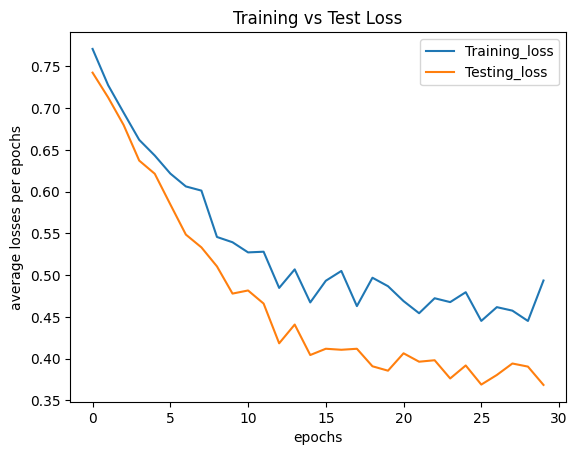

In [24]:
import matplotlib.pyplot as plt
plt.plot(avg_training_loss,label="Training_loss")
plt.plot(avg_testing_loss,label="Testing_loss")
plt.xlabel("epochs")
plt.ylabel("average losses per epochs")
plt.title('Training vs Test Loss')
plt.legend()
plt.show()



In [25]:
model.eval()
all_actual_output = []
all_predicted_ouput = []

predicted_output_count_per_batch = 0
total_count_per_batch = 0
    
#evaluation time we dont wan tto track the gradient
with torch.no_grad():
    for test_feature,test_label in testing_dataloader_set:
        #now this train feature and label we gonna train through GPU
        test_feature = test_feature.to(device)
        test_label   = test_label.to(device)
        
        #first algorithm that work in neural network architecutre is forward propogation algorithm and genearte predicted output
        prediction_output = model.forward(test_feature)
        
        #now checking how many true prediction done by model in each batch by comapring them with threshold value 0.5
        result = (prediction_output.squeeze() >=0.5).float()
        
        correct_predicted_by_model_per_batch = (result == test_label).sum().item()
        
        predicted_output_count_per_batch  = predicted_output_count_per_batch +correct_predicted_by_model_per_batch
        
        #total record count per batch
        count_per_batch = test_label.shape[0]

        total_count_per_batch = total_count_per_batch+count_per_batch
        
        #Collecting all  Actual vs Predicted output 
        all_actual_output.extend(test_label.cpu().numpy())
        all_predicted_ouput.extend(result.cpu().numpy())
        
    print(predicted_output_count_per_batch/total_count_per_batch * 100)

88.80597014925374


# saving model based on best accuracy wrt to comparision